<a href="https://colab.research.google.com/github/hjw705/GraduationWork/blob/master/MaskR_CNN(Detectron2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

ImportError: ignored

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

NameError: ignored

In [ ]:
#!wget http://images.cocodataset.org/val2017/000000005477.jpg -q -O input.jpg
im = cv2.imread("./sample_data/111.jpg")
#im = cv2.imread("./sample_data/dog2_u.png")

cv2_imshow(im)
print(im.shape)
w=im.shape[1]
h=im.shape[0]
#1
im=cv2.resize(im, dsize=(349, 640))
im.shape

AttributeError: ignored

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
mask_rcnn_predictor = DefaultPredictor(cfg)
mask_rcnn_outputs = mask_rcnn_predictor(im)


NameError: ignored

In [ ]:
cfg = get_cfg()
# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
# Load a config from file
cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Use a model from PointRend model zoo: https://github.com/facebookresearch/detectron2/tree/master/projects/PointRend#pretrained-models
cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
print(outputs)

{'instances': Instances(num_instances=1, image_height=640, image_width=349, fields=[pred_boxes: Boxes(tensor([[ 64.5660, 117.2468, 292.6470, 577.7440]], device='cuda:0')), scores: tensor([0.9349], device='cuda:0'), pred_classes: tensor([16], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


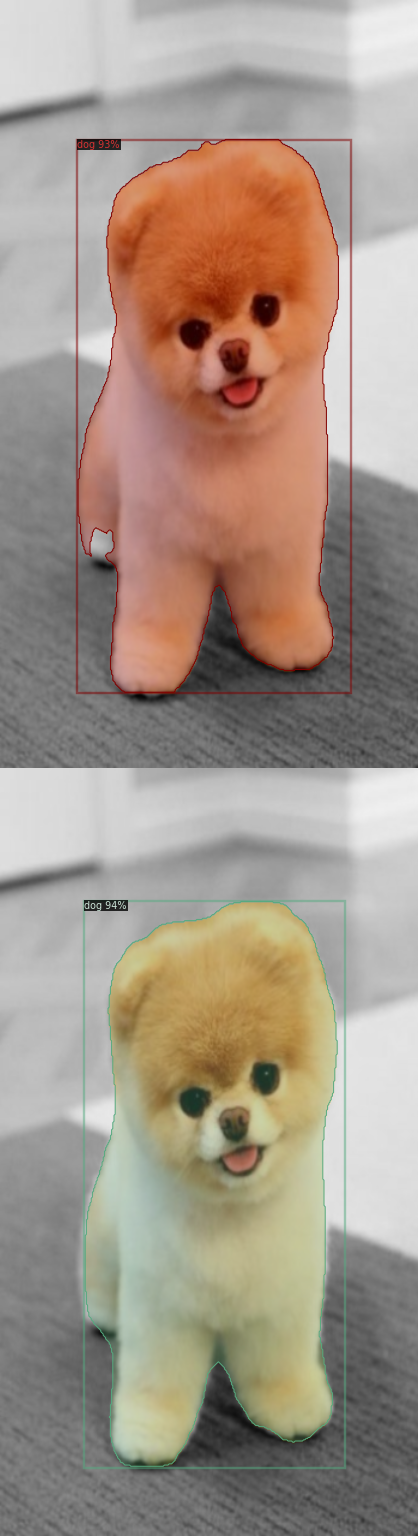

In [ ]:
# Show and compare two predictions: 
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
mask_rcnn_result = v.draw_instance_predictions(mask_rcnn_outputs["instances"].to("cpu")).get_image()
#cv2_imshow(mask_rcnn_result)
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
point_rend_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
cv2_imshow(np.concatenate((point_rend_result, mask_rcnn_result), axis=0)[:, :, ::-1])

In [ ]:
# mask rcnn coordinates
#cor_rcnn = list(mask_rcnn_outputs["instances"].pred_masks[0])
coor_rcnn = mask_rcnn_outputs["instances"].pred_masks[0].cpu().detach().numpy()
im_rcnn = np.zeros((640,349,3), np.uint8)

r=0
g=0
b=0

for i in range(640):
  for j in range(349):
    r+=im[i][j][2]
    g+=im[i][j][1]
    b+=im[i][j][0]

r/=640*349
g/=640*349
b/=640*349

r=256-r
g=256-g
b=256-b

for i in range(640):
  for j in range(349):
    if coor_rcnn[i][j]==True:
      im_rcnn[i][j] = im[i][j]
    else:
      im_rcnn[i][j]=[200, 200, 200]

# pointrend coordinates
coor_point = outputs["instances"].pred_masks[0].cpu().detach().numpy()
im_point = np.zeros((640,349,3), np.uint8)

for i in range(640):
  for j in range(349):
    if coor_point[i][j]==True:
      im_point[i][j] = im[i][j]
    else:
      im_point[i][j] = [0,0,0]


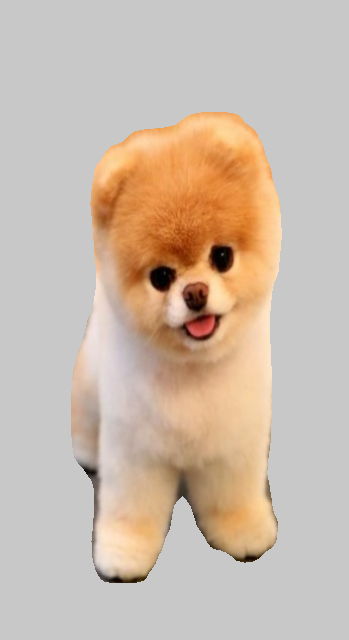

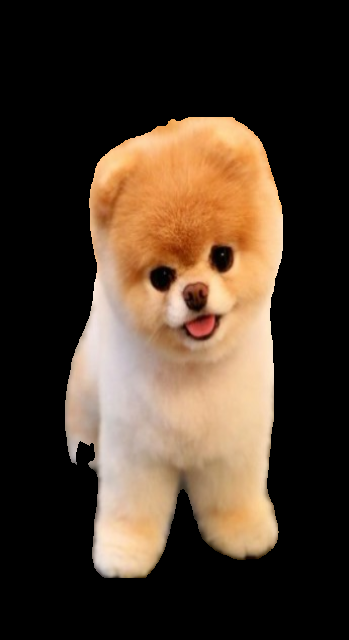

True

In [ ]:
cv2_imshow(im_rcnn)
im_rcnn.shape

cv2_imshow(im_point)
im_rcnn.shape
cv2.imwrite('./sample_data/seg.jpg', im_point)

255
256
640
345 510


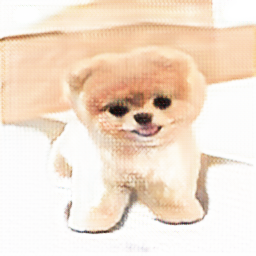

(256, 256)


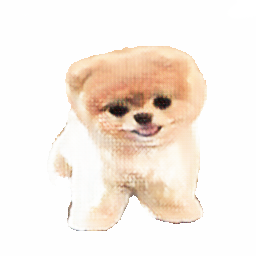

True

In [ ]:
img=cv2.imread('./sample_data/dog3_fake.png')

b_channel, g_channel, r_channel = cv2.split(img)

alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 255 #creating a dummy alpha channel image.

img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
#print(img_BGRA)
print(img_BGRA[100][0][3])
print(len(img_BGRA[0]))
print(len(coor_point))
print(w,h)

coor_point_resized=np.zeros((256,256), np.uint8)
cv2_imshow(img_BGRA)
cv2.imwrite('pre.png', img_BGRA)
for i in range(640):
  for j in range(349):
    coor_point_resized[int(i/640*256)][int(j/349*256)] = coor_point[i][j]

print(coor_point_resized.shape)
# 배경 투명하게
for i in range(256):
  for j in range(256):
    if coor_point_resized[i][j]==False:
      img_BGRA[i][j][3] = 1

cv2_imshow(img_BGRA)
cv2.imwrite('transparent.png', img_BGRA)


In [ ]:
img_BGRA=cv2.resize(img_BGRA, dsize=(w,h))
cv2.imwrite('resized.png', img_BGRA)
print(img.shape)
print(w,h)

(256, 256, 3)
960 960


(256, 256, 3)


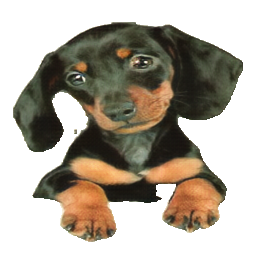

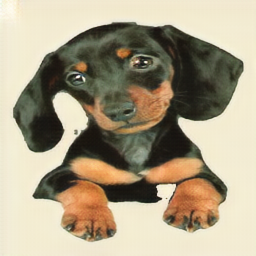

True

In [ ]:
# change back ground color
im_gan = cv2.imread("./sample_data/dog4_seg_r_fake.png")
print(im_gan.shape)
#im_gan=cv2.resize(im_gan, dsize=(349, 640))
# pointrend coordinates
im_gan_point = np.zeros((256, 256,3), np.uint8)

coor_point_resized=np.zeros((256,256), np.uint8)
for i in range(640):
  for j in range(349):
    coor_point_resized[int(i/640*256)][int(j/349*256)] = coor_point[i][j]

for i in range(256):
  for j in range(256):
    if coor_point_resized[i][j].all()==True:
      im_gan_point[i][j] = im_gan[i][j]
    else:
      im_gan_point[i][j] = [255,255,255]
#im_gan_point=cv2.resize(im_gan_point, dsize=(256, 256))
cv2_imshow(im_gan_point)
cv2_imshow(im_gan)
cv2.imwrite('white_bg.jpg', im_gan_point)

In [ ]:
# First we define a simple function to help us plot the intermediate representations.
import matplotlib.pyplot as plt

def plot_mask(mask, title="", point_coords=None, figsize=10, point_marker_size=5):
  '''
  Simple plotting tool to show intermediate mask predictions and points 
  where PointRend is applied.
  
  Args:
    mask (Tensor): mask prediction of shape HxW
    title (str): title for the plot
    point_coords ((Tensor, Tensor)): x and y point coordinates
    figsize (int): size of the figure to plot
    point_marker_size (int): marker size for points
  '''

  H, W = mask.shape
  plt.figure(figsize=(figsize, figsize))
  if title:
    title += ", "
  plt.title("{}resolution {}x{}".format(title, H, W), fontsize=30)
  plt.ylabel(H, fontsize=30)
  plt.xlabel(W, fontsize=30)
  plt.xticks([], [])
  plt.yticks([], [])
  plt.imshow(mask, interpolation="nearest", cmap=plt.get_cmap('gray'))
  if point_coords is not None:
    plt.scatter(x=point_coords[0], y=point_coords[1], color="red", s=point_marker_size, clip_on=True) 
  plt.xlim(-0.5, W - 0.5)
  plt.ylim(H - 0.5, - 0.5)
  plt.show()

In [ ]:
from detectron2.data import transforms as T
model = predictor.model
# In this image we detect several objects but show only the first one.
instance_idx = 0
# Mask predictions are class-specific, "plane" class has id 4.
category_idx = 4

with torch.no_grad():
  # Prepare input image.
  height, width = im.shape[:2]
  im_transformed = T.ResizeShortestEdge(800, 1333).get_transform(im).apply_image(im)
  batched_inputs = [{"image": torch.as_tensor(im_transformed).permute(2, 0, 1)}]

  # Get bounding box predictions first to simplify the code.
  detected_instances = [x["instances"] for x in model.inference(batched_inputs)]
  [r.remove("pred_masks") for r in detected_instances]  # remove existing mask predictions
  pred_boxes = [x.pred_boxes for x in detected_instances] 

  # Run backbone.
  images = model.preprocess_image(batched_inputs)
  features = model.backbone(images.tensor)
  
  # Given the bounding boxes, run coarse mask prediction head.
  mask_coarse_logits = model.roi_heads._forward_mask_coarse(features, pred_boxes)

  plot_mask(
      mask_coarse_logits[instance_idx, category_idx].to("cpu"),
      title="Coarse prediction"
  )


In [ ]:
# Prepare features maps to use later
mask_features_list = [
  features[k] for k in model.roi_heads.mask_point_in_features
]
features_scales = [
  model.roi_heads._feature_scales[k] 
  for k in model.roi_heads.mask_point_in_features
]

In [ ]:
from point_rend.roi_heads import calculate_uncertainty
from point_rend.point_features import get_uncertain_point_coords_with_randomness

# Change number of points to select
num_points = 14 * 14
# Change randomness parameters 
oversample_ratio = 3  # `k` in the paper
importance_sample_ratio = 0.75  # `\beta` in the paper

with torch.no_grad():
  # We take predicted classes, whereas during real training ground truth classes are used.
  pred_classes = torch.cat([x.pred_classes for x in detected_instances])

  # Select points given a corse prediction mask
  point_coords = get_uncertain_point_coords_with_randomness(
    mask_coarse_logits,
    lambda logits: calculate_uncertainty(logits, pred_classes),
    num_points=num_points,
    oversample_ratio=oversample_ratio,
    importance_sample_ratio=importance_sample_ratio
  )

  H, W = mask_coarse_logits.shape[-2:]
  plot_mask(
    mask_coarse_logits[instance_idx, category_idx].to("cpu"),
    title="Sampled points over the coarse prediction",
    point_coords=(
      W * point_coords[instance_idx, :, 0].to("cpu") - 0.5,
      H * point_coords[instance_idx, :, 1].to("cpu") - 0.5
    ),
    point_marker_size=50
  )

In [ ]:
from detectron2.layers import interpolate
from point_rend.roi_heads import calculate_uncertainty
from point_rend.point_features import (
    get_uncertain_point_coords_on_grid,
    point_sample,
    point_sample_fine_grained_features,
)

num_subdivision_steps = 5
num_subdivision_points = 28 * 28


with torch.no_grad():
  plot_mask(
      mask_coarse_logits[0, category_idx].to("cpu").numpy(), 
      title="Coarse prediction"
  )

  mask_logits = mask_coarse_logits
  for subdivions_step in range(num_subdivision_steps):
    # Upsample mask prediction
    mask_logits = interpolate(
        mask_logits, scale_factor=2, mode="bilinear", align_corners=False
    )
    # If `num_subdivision_points` is larger or equalt to the
    # resolution of the next step, then we can skip this step
    H, W = mask_logits.shape[-2:]
    if (
      num_subdivision_points >= 4 * H * W
      and subdivions_step < num_subdivision_steps - 1
    ):
      continue
    # Calculate uncertainty for all points on the upsampled regular grid
    uncertainty_map = calculate_uncertainty(mask_logits, pred_classes)
    # Select most `num_subdivision_points` uncertain points
    point_indices, point_coords = get_uncertain_point_coords_on_grid(
        uncertainty_map, 
        num_subdivision_points
    )

    # Extract fine-grained and coarse features for the points
    fine_grained_features, _ = point_sample_fine_grained_features(
      mask_features_list, features_scales, pred_boxes, point_coords
    )
    coarse_features = point_sample(mask_coarse_logits, point_coords, align_corners=False)

    # Run PointRend head for these points
    point_logits = model.roi_heads.mask_point_head(fine_grained_features, coarse_features)

    # put mask point predictions to the right places on the upsampled grid.
    R, C, H, W = mask_logits.shape
    x = (point_indices[instance_idx] % W).to("cpu")
    y = (point_indices[instance_idx] // W).to("cpu")
    point_indices = point_indices.unsqueeze(1).expand(-1, C, -1)
    mask_logits = (
      mask_logits.reshape(R, C, H * W)
      .scatter_(2, point_indices, point_logits)
      .view(R, C, H, W)
    )
    plot_mask(
      mask_logits[instance_idx, category_idx].to("cpu"), 
      title="Subdivision step: {}".format(subdivions_step + 1),
      point_coords=(x, y)
    )

In [ ]:
from detectron2.modeling import GeneralizedRCNN
from detectron2.modeling.roi_heads.mask_head import mask_rcnn_inference

# 경계 좌표
results = detected_instances
mask_rcnn_inference(mask_logits, results)
results = GeneralizedRCNN._postprocess(results, batched_inputs, images.image_sizes)[0]

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im_transformed[:, :, ::-1], coco_metadata)
v = v.draw_instance_predictions(results["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
len(detected_instances[0])
print(type(detected_instances))
# 좌표 tensor
print(len(detected_instances[0].pred_masks))
# tensor to array
#arr = list(detected_instances[0].pred_masks)
#arr
detected_instances[0].pred_masks
arr = list(results["instances"][0].pred_masks)
#len(results["instances"][0].pred_masks)
im.shape